In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import cv2
import os
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/smoking/Training/Training'
test_path = '/kaggle/input/smoking/Testing/Testing'
val_path = '/kaggle/input/smoking/Validation/Validation'

In [3]:
def load_and_preprocess_images(file_paths, target_size=(250, 250)):
    images = []
    for file_path in file_paths:
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Zamień format BGR na RGB
        img = cv2.resize(img, target_size)
        img_array = img.astype(np.float32) / 255.0
        images.append(img_array)
    return np.array(images)

X_train = load_and_preprocess_images([os.path.join(train_path, filename) for filename in os.listdir(train_path)])
X_test = load_and_preprocess_images([os.path.join(test_path, filename) for filename in os.listdir(test_path)])
X_val = load_and_preprocess_images([os.path.join(val_path, filename) for filename in os.listdir(val_path)])

In [4]:
single_image = np.array(X_train[0])

print("Single image shape:", single_image.shape)

Single image shape: (250, 250, 3)


In [5]:
def assign_class_from_filename(filename):
    if filename.lower().startswith("smoking"):
        return 1 
    else:
        return 0

y_train = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Training/Training/')]

y_test = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Testing/Testing/')]

y_val = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Validation/Validation/')]

unique_classes = set(y_train + y_test + y_val)
print("Unikalne klasy:", unique_classes)

Unikalne klasy: {0, 1}


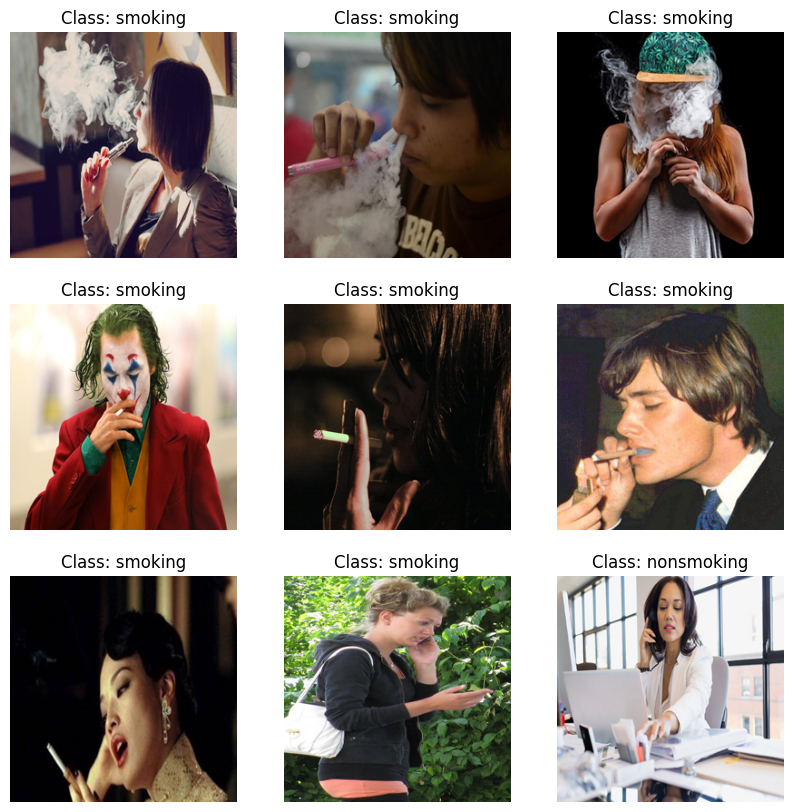

In [6]:
sample_indices = np.random.randint(0, len(X_train), 9)

plt.figure(figsize=(10, 10))
for i, index in enumerate(sample_indices):
    image = X_train[index]
    label = y_train[index]
    class_name = "smoking" if label == 1 else "nonsmoking"
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis("off")

plt.show()

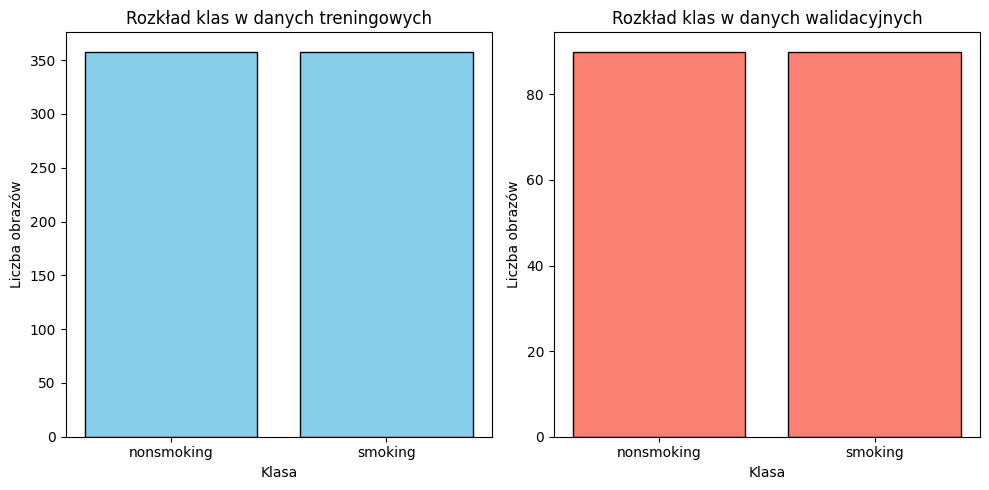

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=[-0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8, color='skyblue')
plt.xticks([0, 1], ['nonsmoking', 'smoking'])
plt.title('Rozkład klas w danych treningowych')
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')

plt.subplot(1, 2, 2)
plt.hist(y_val, bins=[-0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8, color='salmon')
plt.xticks([0, 1], ['nonsmoking', 'smoking'])
plt.title('Rozkład klas w danych walidacyjnych')
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')

plt.tight_layout()
plt.show()

In [8]:
num_classes = len(unique_classes)

X_train = np.array(X_train)
y_train_one_hot = to_categorical(y_train, num_classes)
X_val = np.array(X_val)
y_val_one_hot = to_categorical(y_val, num_classes)
X_test = np.array(X_test)
y_test_one_hot = to_categorical(y_test, num_classes)

X_train_original = np.copy(X_train)
y_train_original_one_hot = np.copy(y_train_one_hot)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [9]:
augmented_indices_train = random.sample(range(len(X_train)), int(len(X_train)))

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

selected_images_generator_train = (X_train[i] for i in augmented_indices_train)

X_selected_resized_augmented_train = []
num_augmentations = 5  

for img in selected_images_generator_train:
    augmented_images = [datagen.random_transform(img) for _ in range(num_augmentations)]
    X_selected_resized_augmented_train.extend(augmented_images)

X_selected_resized_augmented_train = np.array(X_selected_resized_augmented_train)
y_train_augmented_one_hot = np.repeat(y_train_one_hot[augmented_indices_train], num_augmentations, axis=0)

X_train_combined = np.concatenate([X_train_original, X_selected_resized_augmented_train], axis=0)
y_train_combined_one_hot = np.concatenate([y_train_original_one_hot, y_train_augmented_one_hot], axis=0)

print("X_train_original shape:", X_train_original.shape)
print("y_train_original_one_hot shape:", y_train_original_one_hot.shape)
print("X_selected_resized_augmented_train shape:", X_selected_resized_augmented_train.shape)
print("y_train_augmented_one_hot shape:", y_train_augmented_one_hot.shape)
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined_one_hot shape:", y_train_combined_one_hot.shape)

X_train_original shape: (716, 250, 250, 3)
y_train_original_one_hot shape: (716, 2)
X_selected_resized_augmented_train shape: (3580, 250, 250, 3)
y_train_augmented_one_hot shape: (3580, 2)
X_train_combined shape: (4296, 250, 250, 3)
y_train_combined_one_hot shape: (4296, 2)


In [10]:
X_train = tf.image.resize(X_train_combined, (32, 32)).numpy()
X_val = tf.image.resize(X_val, (32, 32)).numpy()
X_test = tf.image.resize(X_test, (32, 32)).numpy()

In [11]:
y_train = y_train_combined_one_hot
y_val = y_val_one_hot

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train_one_hot shape:", y_train.shape)
print("y_val_one_hot shape:", y_val.shape)

X_train shape: (4296, 32, 32, 3)
X_val shape: (180, 32, 32, 3)
y_train_one_hot shape: (4296, 2)
y_val_one_hot shape: (180, 2)


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
135/135 [==============================] - 10s 10ms/step - loss: 0.6922 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6839 - accuracy: 0.5270 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6361 - accuracy: 0.6318 - val_loss: 0.5722 - val_accuracy: 0.7222
Epoch 4/100
135/135 [==============================] - 1s 4ms/step - loss: 0.5899 - accuracy: 0.6962 - val_loss: 0.5612 - val_accuracy: 0.7333
Epoch 5/100
135/135 [==============================] - 1s 5ms/step - loss: 0.5812 - accuracy: 0.7062 - val_loss: 0.5638 - val_accuracy: 0.7333
Epoch 6/100
135/135 [==============================] - 1s 5ms/step - loss: 0.5705 - accuracy: 0.7102 - val_loss: 0.5651 - val_accuracy: 0.7222
Epoch 7/100
135/135 [==============================] - 1s 4ms/step - loss: 0.5645 - accuracy: 0.7116 - val_loss: 0.5570 - val_accuracy: 0.71

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

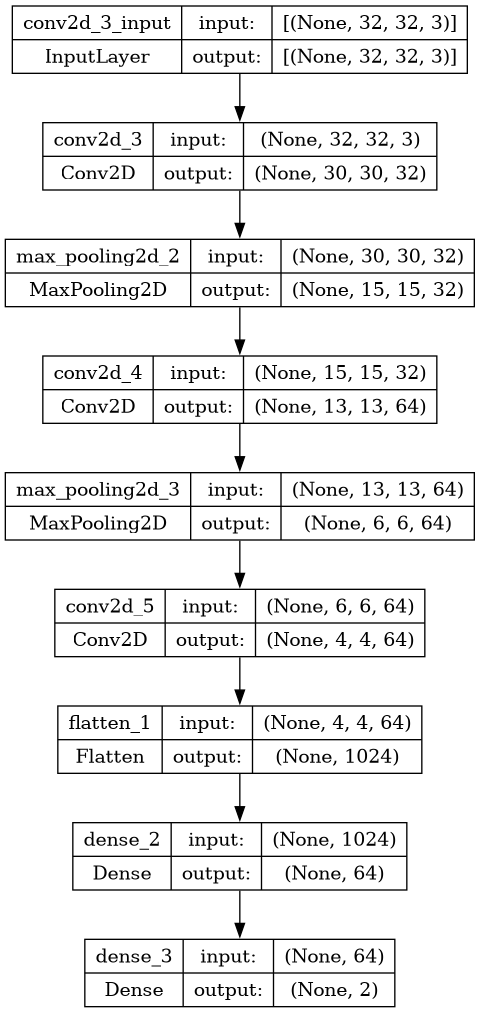

In [15]:
#NN visualization
model.summary()
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

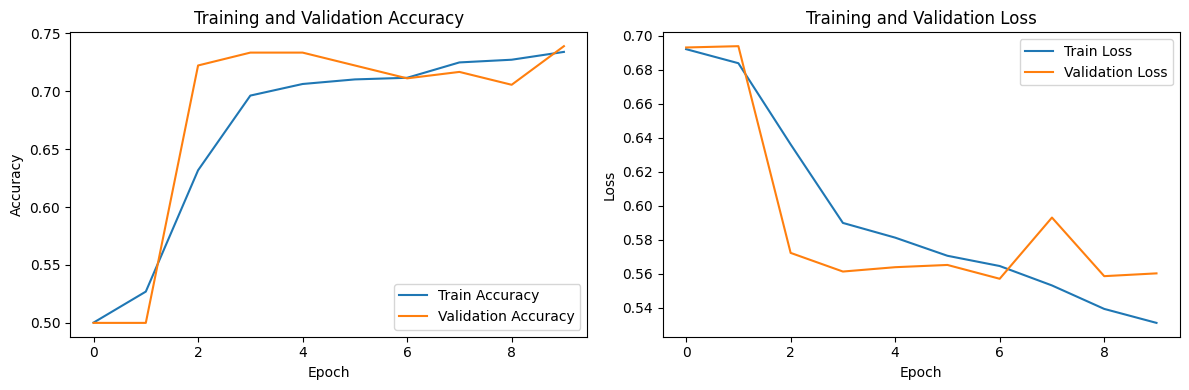

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'),
    tf.keras.layers.Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu'),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(units =2  , activation = 'softmax')
])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2023-12-28 08:46:43.716107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 4s 10ms/step - loss: 0.6938 - accuracy: 0.5175 - val_loss: 0.6811 - val_accuracy: 0.5333
Epoch 2/100
135/135 [==============================] - 1s 8ms/step - loss: 0.6915 - accuracy: 0.5126 - val_loss: 0.6931 - val_accuracy: 0.6222
Epoch 3/100
135/135 [==============================] - 1s 8ms/step - loss: 0.6929 - accuracy: 0.5279 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 4/100
135/135 [==============================] - 1s 8ms/step - loss: 0.6935 - accuracy: 0.4867 - val_loss: 0.6932 - val_accuracy: 0.5000


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        3136      
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        65600     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 128)       131200    
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         262272    
                                                      

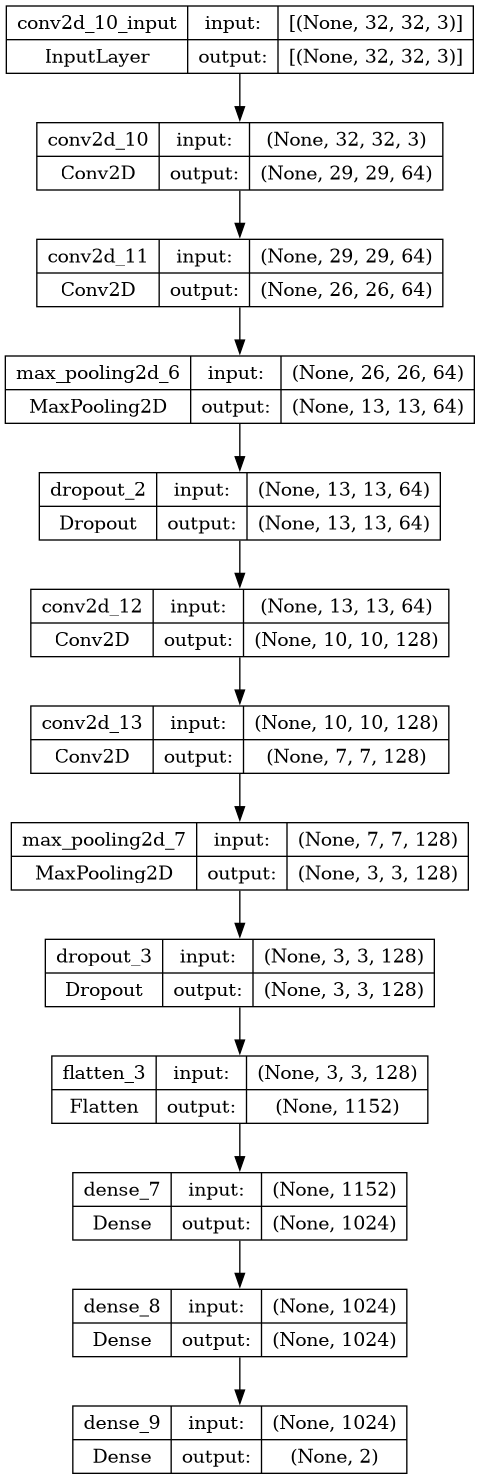

In [19]:
model_1.summary()
plot_model(model_1, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

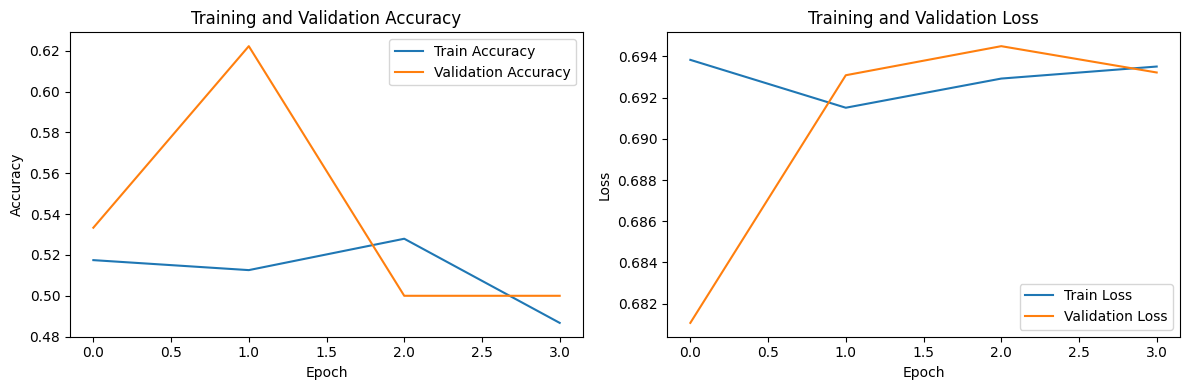

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 2  , activation = 'softmax')
])

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2023-12-28 08:47:35.761574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 9s 24ms/step - loss: 0.8985 - accuracy: 0.6092 - val_loss: 1.3493 - val_accuracy: 0.5000
Epoch 2/100
135/135 [==============================] - 3s 19ms/step - loss: 0.7422 - accuracy: 0.6588 - val_loss: 0.7758 - val_accuracy: 0.5000
Epoch 3/100
135/135 [==============================] - 3s 19ms/step - loss: 0.6906 - accuracy: 0.6650 - val_loss: 0.9382 - val_accuracy: 0.5000
Epoch 4/100
135/135 [==============================] - 3s 19ms/step - loss: 0.6470 - accuracy: 0.6692 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 5/100
135/135 [==============================] - 3s 19ms/step - loss: 0.6163 - accuracy: 0.6895 - val_loss: 0.5857 - val_accuracy: 0.7667
Epoch 6/100
135/135 [==============================] - 3s 19ms/step - loss: 0.6104 - accuracy: 0.6916 - val_loss: 0.6644 - val_accuracy: 0.5500
Epoch 7/100
135/135 [==============================] - 3s 19ms/step - loss: 0.6169 - accuracy: 0.6885 - val_loss: 0.9175 - val_accuracy: 0.5000
Epoc

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                      

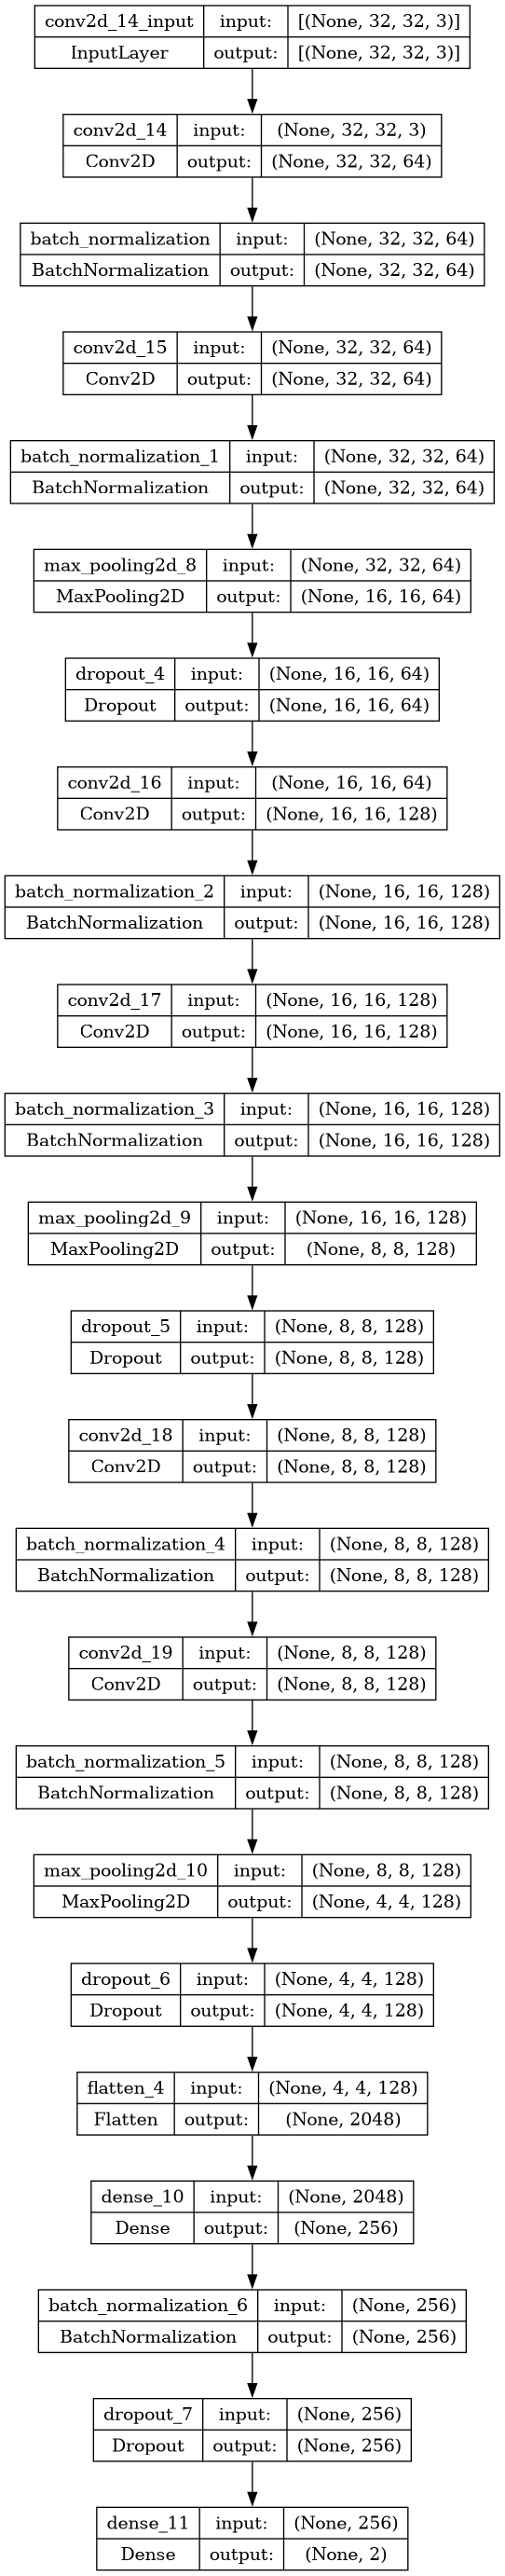

In [22]:
model_2.summary()
plot_model(model_2, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

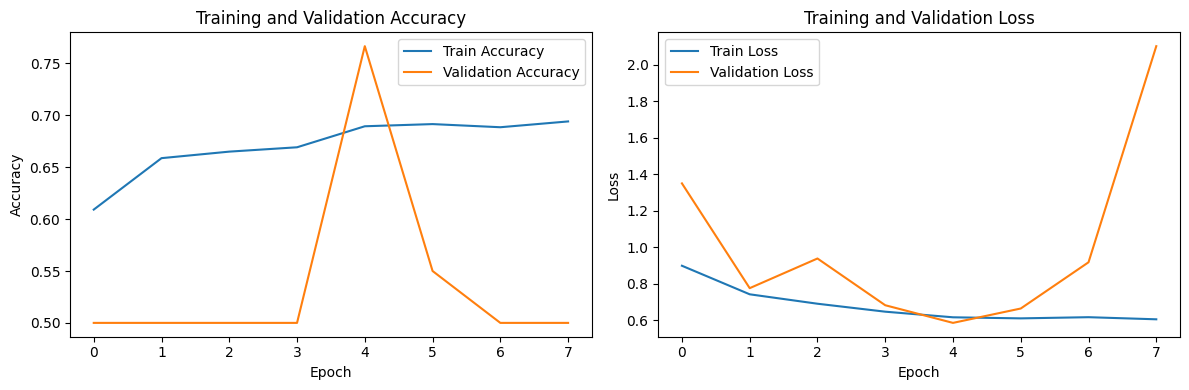

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
y_true = np.argmax(y_test_one_hot, axis=1)
y_pred_probabilities = model_2.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

7/7 [==============================] - 0s 8ms/step
Accuracy: 0.7098
Precision: 0.7325
Recall: 0.7098
F1-Score: 0.7026

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.55      0.66       112
           1       0.66      0.87      0.75       112

    accuracy                           0.71       224
   macro avg       0.73      0.71      0.70       224
weighted avg       0.73      0.71      0.70       224



In [26]:
baseline_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = baseline_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
135/135 [==============================] - 2s 4ms/step - loss: 0.7503 - accuracy: 0.5526 - val_loss: 0.6681 - val_accuracy: 0.6500
Epoch 2/100
135/135 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.6657 - val_loss: 0.6356 - val_accuracy: 0.7722
Epoch 3/100
135/135 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.6885 - val_loss: 0.6074 - val_accuracy: 0.7778
Epoch 4/100
135/135 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6983 - val_loss: 0.5958 - val_accuracy: 0.7278
Epoch 5/100
135/135 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.7062 - val_loss: 0.5795 - val_accuracy: 0.7333
Epoch 6/100
135/135 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6946 - val_loss: 0.5751 - val_accuracy: 0.7333
Epoch 7/100
135/135 [==============================] - 0s 3ms/step - loss: 0.5835 - accuracy: 0.7081 - val_loss: 0.5677 - val_accuracy: 0.7333

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               393344    
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 393602 (1.50 MB)
Trainable params: 393602 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


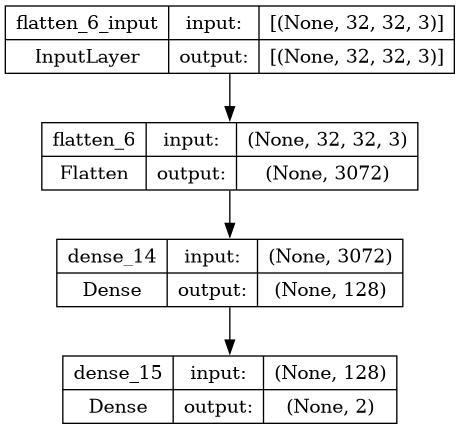

In [27]:
baseline_model.summary()
plot_model(baseline_model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

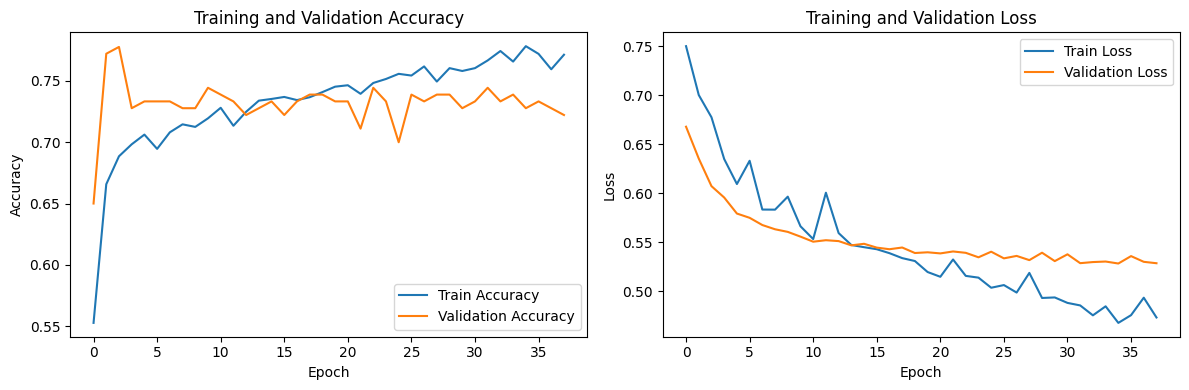

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], label='Train Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
model_1 = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model_1.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
135/135 [==============================] - 2s 5ms/step - loss: 0.7791 - accuracy: 0.5205 - val_loss: 0.6564 - val_accuracy: 0.7333
Epoch 2/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6655 - val_loss: 0.5993 - val_accuracy: 0.7444
Epoch 3/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6227 - accuracy: 0.6704 - val_loss: 0.5844 - val_accuracy: 0.7333
Epoch 4/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6216 - accuracy: 0.6641 - val_loss: 0.5786 - val_accuracy: 0.7278
Epoch 5/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6127 - accuracy: 0.6699 - val_loss: 0.5766 - val_accuracy: 0.7500
Epoch 6/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6112 - accuracy: 0.6697 - val_loss: 0.5672 - val_accuracy: 0.7389
Epoch 7/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6129 - accuracy: 0.6746 - val_loss: 0.5576 - val_accuracy: 0.7333